# Propagación hacia atrás

En esta sección vamos a crear nuestra primera red neuronal capaz de aprender.

## Cargamos los datos

Para hacer un ejemplo relativamente sencillo, vamos a resolver un problema de clasificación binaria usando el dataset del Cancer de Mama, que ya hemos visto anteriormente. Recordemos que es un dataset donde las variables independientes son medidas hechas de una imágen de un posible tumor y la variable objetivo es un 0 (cancer maligno) o un 1 (cancer benigno)

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target

Usamos solo las 4 primeras variables para que el input coincida con la capa de entrada de la red

In [3]:
X = data.data[:,:4]

In [4]:
X.shape

(569, 4)

Para entrenar una red neuronal es muy importante que los datos estén normalizados, si no lo son la red le va a dar más importancia a aquellas variables cuyo rango sea más grande.

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
x_estandardizador = StandardScaler()
X_std = x_estandardizador.fit_transform(X)

In [7]:
x0 = X_std[0]
y0 = y[0]
print(x0, y0)

[ 1.09706398 -2.07333501  1.26993369  0.9843749 ] 0


### Creación de la red neuronal

E implementaremos el algoritmo de propagación hacia atrás (backpropagation) que es lo que permitirá que la red aprenda.

Es decir, una capa de entrada con 4 neuronas (*también llamadas **unidades**^), una capa oculta con 5 neuronas y una capa de salida que convertirá los outputs (o **activaciones** de la capa oculta en clase positiva o negativa

En primer lugar definimos las funciones de activación distintas:
- ** Función identidad**, que se usa en la capa de entrada y no hace nada (o sea, $f(x)=x$)
- **Función Sigmoide**, que aplica la función sigmoide $f(x)=\frac{1}{1+e^{-x}}$ que convierte los números al rango `[0,1]` y que se usa para problemas de clasificación binaria

In [8]:
def fn_identidad(x, derivada=False):
    if derivada:
        return np.ones(x.shape)
    return x
                
def fn_sigmoide(x, derivada=False):
    if derivada:
        return x*(1-x)
    return 1/(1+np.exp(-x))

también tenemos que definir una manera de computar el error de una predicción (error, coste y perdida se usan indistintamente).

Para un problema de clasificación binaria, una buena métrica es la pérdida logarítmica ([logloss](http://wiki.fast.ai/index.php/Log_Loss))

In [9]:
def error_logloss(y_pred, y):
    p = np.clip(y_pred, 1e-15, 1 - 1e-15)
    if y == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)    

En primer lugar, definimos la capa básica, que tiene un número de unidades un bias, y una función de activación

In [10]:
class Layer:
    def __init__(self, n_unidades, fn_activacion, bias=True):
        self.n_unidades = n_unidades
        self.fn_activacion = fn_activacion
        self.dim_output = n_unidades
        
        # añadimos un peso más para la unidad de bias
        self.bias = bias

        self.dimensiones = "no generada"
        self.w = None
        
    def __repr__(self):
        return """
        Capa {}. dimensiones = {}.
        pesos: {}
        """.format(
        self.nombre, self.dimensiones, self.w)
    
    def generar_pesos(self, dim_output_anterior):
        if self.bias:
            self.dimensiones = (self.n_unidades, dim_output_anterior+1)
        else:
            self.dimensiones = (self.n_unidades, dim_output_anterior)
        self.w = np.random.random(self.dimensiones)

    def add_bias(self, x):
        if not self.bias:
            return x
        x_con_bias_1d = np.append(1, x)
        # append convierte en array 1dimensional necesitamos 2d
        return x_con_bias_1d.reshape(
             x_con_bias_1d.shape[0], 1
        )
    
    def activar(self, x):
        x_con_bias_2d = self.add_bias(x)
        return self.fn_activacion( self.w @ x_con_bias_2d )

    def calcular_delta(self, producto_capa, output_capa):
        return producto_capa * self.fn_activacion(output_capa, derivada=True)

Tenemos 3 tipos de Capas de neuronas.

- **Capa de Entrada**, no hace nada, simplemente conecta el input con el resto de la red
- **Capa Oculta**, también llamada capa densa, realiza el algoritmo perceptrón con una función de activación no lineal
- **Capa de Salida**, esta capa traduce el output de la capa antepenúltima a la variable objetivo deseada

In [11]:
class InputLayer(Layer):
    nombre = "entrada"

    def generar_pesos(self):
        pass      
    
    def activar(self, x):
        return x

class HiddenLayer(Layer):
    nombre = "oculta"
    
class OutputLayer(Layer):
    nombre = "salida"   

Ahora creamos la red neuronal, que es simplemente una lista de capas y con capacidad de hacer propagación hacia delante y hacia atrás.

In [12]:
class RedNeuronal:
    def __init__(self, ratio_aprendizaje, fn_error):
        self.layers = []
        self.ratio_aprendizaje = ratio_aprendizaje
        self.fn_error = fn_error
        
    def add_layer(self, layer):
        if layer.nombre == "entrada":
            layer.generar_pesos()
        else:
            layer.generar_pesos(self.layers[-1].dim_output)
        self.layers.append(layer)
            
    def __repr__(self):
        info_red = ""
        for layer in self.layers:
            info_red += "\nCapa: {} Nº unidades: {}".format(
                        layer.nombre, layer.n_unidades)
        return info_red
    
    def forward(self, x):
        
        for layer in self.layers:
            layer.input = layer.add_bias(x).T
            x = layer.activar(x)
            layer.output = x
        return x
    
    def calcular_error_prediccion(self, y_pred, y):
        return self.fn_error(y_pred, y)
    
    def backward(self, y_pred, y):
        # El error de prediccion final
        delta_capa = self.calcular_error_prediccion(y_pred, y)
        for layer in reversed(self.layers):
            if layer.nombre == "entrada":
                continue    
            if layer.nombre == "salida":
                producto_capa = delta_capa @ layer.w
            else:
                #quitamos el error del bias de la capa anterior
                producto_capa = delta_capa[:,1:] @ layer.w
            delta_capa = layer.calcular_delta(producto_capa, layer.output) 
            layer.delta = delta_capa       
                   
                
    def actualizar_pesos(self):
        """
        Actualiza pesos mediante el descenso de gradiente"""
        for layer in self.layers[1:]:
            layer.w = layer.w - self.ratio_aprendizaje \
                      *layer.delta * layer.input

    def aprendizaje(self, x, y):
        """
        Función principal para entrenar la red
        """
        y_pred = self.forward(x)
        self.backward(y_pred, y)
        self.actualizar_pesos()
        error_prediccion = self.calcular_error_prediccion(y_pred, y)
        return error_prediccion

    def predict_proba(self, x):
        return self.forward(x)
    
    def predict(self, x):
        probabilidad = self.predict_proba(x)
        if probabilidad>=0.5:
            return 1
        else:
            return 0

#### Creación de la red neuronal

En primer lugar tenemos que definir los tamaños de cada capa, y si van a incluir sesgo (bias) o no.

In [13]:
n_input = 4
n_oculta = 5
n_output = 1

RATIO_APRENDIZAJE = 0.0001
N_ITERACIONES=1000

In [14]:
red_sigmoide = RedNeuronal(ratio_aprendizaje=RATIO_APRENDIZAJE, fn_error=error_logloss)

red_sigmoide.add_layer(InputLayer(n_input, bias=False, fn_activacion=fn_identidad))
red_sigmoide.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_sigmoide))
red_sigmoide.add_layer(OutputLayer(n_output, fn_activacion=fn_sigmoide))

Inicialmente la red tiene unos pesos aleatorios

In [15]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.05932494 0.24002885 0.66561425 0.03369015 0.55745208]
  [0.01307787 0.16667856 0.44976436 0.9244284  0.47386299]
  [0.56518781 0.99349898 0.68299224 0.48427677 0.0355443 ]
  [0.50687102 0.4316548  0.42592077 0.92394299 0.37949805]
  [0.29611987 0.72878692 0.31099663 0.40218879 0.54189634]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.18205487 0.06283305 0.96899124 0.77975458 0.60936569 0.75709972]]
         ]

Si ahora hacemos una iteración del proceso de aprendizaje:

In [16]:
red_sigmoide.aprendizaje(x0, y0)

array([[2.65090077]])

Vemos que los pesos de las capas se han actualizado

In [17]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.05932086 0.24002087 0.6656271  0.03367893 0.55744736]
  [0.01307433 0.16667165 0.4497755  0.92441869 0.47385891]
  [0.56518425 0.99349202 0.68300345 0.484267   0.03554018]
  [0.50686869 0.43165022 0.42592813 0.92393657 0.37949535]
  [0.29611729 0.72878188 0.31100475 0.40218171 0.54189336]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.18205171 0.06283263 0.96897925 0.77974497 0.60935681 0.75708897]]
         ]

Esto es el equivalente a hacer los siguientes pasos:

In [18]:
prediccion = red_sigmoide.forward(x0)
prediccion

array([[0.9294084]])

In [19]:
red_sigmoide.backward(prediccion, y0)

In [20]:
red_sigmoide.actualizar_pesos()

In [21]:
red_sigmoide.layers

[
         Capa entrada. dimensiones = no generada.
         pesos: None
         ,
 
         Capa oculta. dimensiones = (5, 5).
         pesos: [[0.05931678 0.24001289 0.66563996 0.03366772 0.55744264]
  [0.0130708  0.16666473 0.44978664 0.92440898 0.47385482]
  [0.5651807  0.99348507 0.68301465 0.48425723 0.03553607]
  [0.50686635 0.43164565 0.42593549 0.92393015 0.37949264]
  [0.29611472 0.72877683 0.31101287 0.40217463 0.54189038]]
         ,
 
         Capa salida. dimensiones = (1, 6).
         pesos: [[0.18204854 0.06283221 0.96896725 0.77973536 0.60934793 0.75707821]]
         ]

Ya tenemos una red neuronal que aprende para optimizar una observación usando el método del descenso de gradiente. Ahora solo tenemos que implementar el método de descenso estocástico de gradiente (SGD) para iterar en todo el dataset de entrenamiento e ir modificando los pesos para minimizar los errores de entrenamiento

In [22]:
def iteracion_sgd(red, X, y):
    # barajamos los datos de entrenamiento
    indice_aleatorio = np.random.permutation(X.shape[0])
    error =  []
    # iteramos todo el dataset
    for i in range(indice_aleatorio.shape[0]):
        x0 = X[indice_aleatorio[i]]
        y0 = y[indice_aleatorio[i]]
        err = red.aprendizaje(x0, y0)
        error.append(err)
    return np.nanmean(np.array(error))

def entrenar_sgd(red, n_epocas, X, y):
    epocas = []
    for epoca in range(n_epocas):
        error_epoca = iteracion_sgd(red, X, y)
        epocas.append([epoca, error_epoca])
    return np.array(epocas)

Ahora por ejemplo corremos el algoritmo durante varias iteraciones.

In [23]:
resultados_sigmoide = entrenar_sgd(red_sigmoide, N_ITERACIONES, X_std, y)

Si ahora visualizamos la evolución del error medio

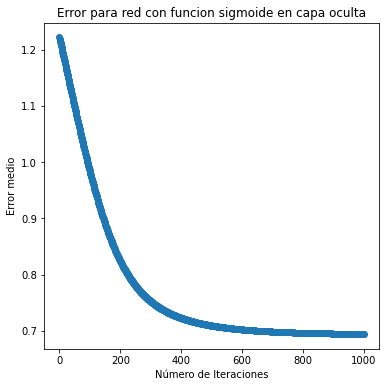

In [24]:
plt.scatter(x=resultados_sigmoide[:,0], y=resultados_sigmoide[:,1])
plt.title("Error para red con funcion sigmoide en capa oculta")
plt.xlabel("Número de Iteraciones")
plt.ylabel("Error medio");

Vemos que a cada iteración (época) de aprendizaje el error medio total se va reduciendo

Lo bueno de las redes neuronales es que tienen una flexibilidad que otros modelos no tienen.

Por ejemplo podemos cambiar la función de activación de la capa oculta.

En la práctica la función sigmoide no se usa para capas ocultas, se suele usar más la **Unidad Linear rectificada (ReLU)**.

In [25]:
def fn_relu(x, derivada=False):
    if derivada:
        return 1. * (x>0.)
    return np.maximum(x, 0.)

def fn_leakyrelu(x, derivada=False):
    if derivada:
        if x.any()>0:
            return 1.
        else:
            return 0.01
    return np.maximum(x, 0.01*x)

o incluso modificar la red y añadir otra capa con el doble de unidades

In [26]:
red_relu = RedNeuronal(ratio_aprendizaje=RATIO_APRENDIZAJE, fn_error=error_logloss)
red_relu.add_layer(InputLayer(n_input, bias=False, fn_activacion=fn_identidad))
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(HiddenLayer(n_oculta, fn_activacion=fn_relu))
red_relu.add_layer(OutputLayer(n_output, fn_activacion=fn_sigmoide))

In [27]:
resultados_relu = entrenar_sgd(red_relu, N_ITERACIONES, X_std, y)

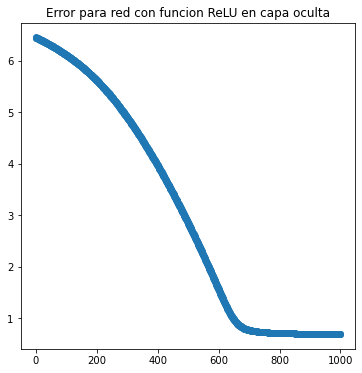

In [28]:
plt.scatter(x=resultados_relu[:,0], y=resultados_relu[:,1])
plt.title("Error para red con funcion ReLU en capa oculta");